## <u> go_chandra - Python </u>

The follwoing code is a script adapted from Gladstone's *go_chandra* IDL script.

The code takes the corrected file from *sso_freeze* (hardwired by user), peforms a corrdinate transformation on the X-ray emission to wrap the PSF around Jupiter and plots the emission of the poles.

In [1]:
#Purpose: New public Python pipeline used to produce polar plots of Jupiter's X-ray emission over the full observation and/or over defined time
# intervals. IF using plots produced by this pipeline, please cite Weigt et al. (in prep.) where the pipleine is discussed in some 
# detail
#Category: 
#Authors: Dale Weigt (D.M.Weigt@soton.ac.uk), apadpted from Randy Gladstone's 'gochandra' IDL script

"""All the relevant packages are imported for code below"""

import go_chandra_analysis_tools as gca_tools # import the defined functions to analysis Chandra data nad perfrom coordinate transformations
import custom_cmap as make_me_colors # import custom color map script 
import label_maker as make_me_labels # import script to label mutliple subplots

import numpy as np
import pandas as pd
import scipy
import numpy as np
import math
import pandas as pd

import scipy
from scipy import interpolate
from scipy.io import readsav

from astropy.io import ascii
from astropy.visualization import astropy_mpl_style
from astropy.io import fits as pyfits
from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table, Column
from astropy import units as u
from astropy.units import imperial
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve, Box1DKernel

import matplotlib
from matplotlib import pyplot as plt
#from matplotlib.widgets import RectangleSelector
from matplotlib import ticker, cm
from matplotlib import colors

import matplotlib.gridspec as gridspec

from numpy.random import poisson 

import time
from distutils.version import LooseVersion
import datetime
from datetime import datetime, timedelta
import calendar
import aplpy as apl

import glob
import os


"""Setup the font used for plotting"""

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['xtick.labelsize']=14
matplotlib.rcParams['ytick.labelsize']=14
matplotlib.rcParams['agg.path.chunksize'] = 1000000

# AU to meter conversion - useful later on (probably a function built in already)
AU_2_m = 1.49598E+11
AU_2_km = 1.49598E+8

C:\Users\dmw1n18\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### Reading in Chandra Event file, extracting all the relevant info and defining assumptions used in analysis <br>

User is prompted to enter the file path of the corrected event file. The script finds the file from the selected folder and reads in all the relevent headers. The asusmptions used for the mapping are also defined here.

In [2]:
# User prompted to enter the file path of the corrected file
folder_path = input('Enter file path of event file to be analysed (post correction): ')

cor_evt_location = []
# Script then searches through the folder looking the filename corresponding to the corrected file
for file in glob.glob(str(folder_path) + r"\hrcf*_pytest_evt2.fits"):
    cor_evt_location.append(file)

# File is then read in with relevant header information extracted:
hdulist = pyfits.open(cor_evt_location[0], dtype=float)
matplotlib.rcParams['agg.path.chunksize'] = 10000
img_events=hdulist['EVENTS'].data # the data of the event file
img_head = hdulist[1].header # the header information of the event file
#img_data = hdulist[1].data
bigtime = img_events['time'] # time
bigxarr = img_events['X'] # x position of photons
bigyarr = img_events['Y'] # y position of photons
bigchannel = img_events['pha'] # pha channel the photons were found in
obs_id = img_head['OBS_ID'] # observation id of the event
tstart = img_head['TSTART'] # the start and...
tend = img_head['TSTOP'] #... end time of the observation

# The date of the observation is read in...
datestart = img_head['DATE-OBS']
evt_date = pd.to_datetime(datestart) #... and coverted to datetiem format to allow the relevant information to be read to...
evt_hour = evt_date.hour
evt_doy = evt_date.strftime('%j')
evt_mins = evt_date.minute
evt_secs = evt_date.second
evt_DOYFRAC = gca_tools.doy_frac(float(evt_doy), float(evt_hour), float(evt_mins), float(evt_secs)) #... calculated a fractional Day of 
# Year (DOY) of the observation

ra_centre, ra_centre_rad = img_head['RA_NOM'], np.deg2rad(img_head['RA_NOM']) # the RA of Jupiter at the centre of the chip is read in as...
dec_centre, dec_centre_rad = img_head['DEC_NOM'], np.deg2rad(img_head['DEC_NOM']) #... well as Jupitr's DEC
j_rotrate = np.rad2deg(1.758533641E-4) # Jupiter's rotation period

hdulist.close()

# Assumptions used for mapping:
scale = 0.13175 # scale used when observing Jupiter using Chandra - in units of arcsec/pixel
fwhm = 0.8 # FWHM of the HRC-I point spread function (PSF) - in units of arcsec
psfsize = 25 # size of PSF used - in units of arcsec
alt = 400 # altitude where X-ray emission assumers to occur in Jupiter's ionosphere - in units of km

Enter file path of event file to be analysed (post correction): C:\Users\dmw1n18\Documents\PhD\Chandra\Data\16300\primary


### Reading in Jupiter Horizon's file

Alogrithm uses the start and end date from the observation to generate an epheremis file (from the JPL Horizons server) to use for analysis. The ephermeris file used takes CXO as the observer

In [3]:
"""Brad's horizons code to extract the ephemeris file"""
import astropy as astropy
import astroquery
from bs4 import BeautifulSoup
import operator     #subtract arrays
from astropy.io import fits                     #input .fits files
from astropy import wcs 
from matplotlib.ticker import MultipleLocator
from astropy.time import Time                   #convert between different time coordinates
from astropy.time import TimeDelta              #add/subtract time intervals 
from scipy.interpolate import interp1d          #interpolate functions
from astropy import wcs
#-*- coding: utf-8 -*-
from astroquery.jplhorizons import Horizons     #automatically download ephemeris 
#Need to do this to fix astroquery bug, otherwise it won't find the ephemeris data
from astroquery.jplhorizons import conf
conf.horizons_server = 'https://ssd.jpl.nasa.gov/horizons_batch.cgi'

# The start and end times are taken from the horizons file.
tstart_eph=Time(tstart, format='cxcsec') 
tstop_eph=Time(tend, format='cxcsec')
eph_tstart = Time(tstart_eph, out_subfmt='date_hm')
dt = TimeDelta(0.125, format='jd') 
eph_tstop = Time(tstop_eph + dt, out_subfmt='date_hm')
# Below sets the parameters of what observer the ephemeris file is generated form. For example, '500' = centre of the Earth, '500@-151' = CXO
obj = Horizons(id=599,location='500@-151',epochs={'start':eph_tstart.iso, 'stop':eph_tstop.iso, 'step':'1m'}, id_type='majorbody')
eph_jup = obj.ephemerides()

# Extracts relevent information needed from ephermeris file
cml_spline_jup = scipy.interpolate.UnivariateSpline(eph_jup['datetime_jd'], eph_jup['PDObsLon'],k=1)
lt_jup = eph_jup['lighttime']
sub_obs_lon_jup = eph_jup['PDObsLon']
sub_obs_lat_jup = eph_jup['PDObsLat']

eph_dates = pd.to_datetime(eph_jup['datetime_str']) 
eph_dates = pd.DatetimeIndex(eph_dates)
eph_doy = np.array(eph_dates.strftime('%j')).astype(int)
eph_hours = eph_dates.hour
eph_minutes = eph_dates.minute
eph_seconds = eph_dates.second

eph_DOYFRAC_jup = gca_tools.doy_frac(eph_doy, eph_hours, eph_minutes, eph_seconds) # DOY fraction from ephermeris data

jup_time = (eph_DOYFRAC_jup - evt_DOYFRAC)*86400.0 + tstart # local tiem of Jupiter

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


### Select Region for analysis

Plots the photons (x,y) position on a grid of defined size in arcseconds (defualted at [-50,50] in both x and y). Jupiter is centred on the HRC instrument. The photon information form the defined 

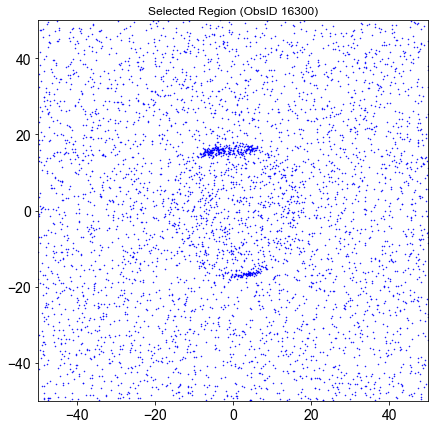

In [4]:
# converting the x and y coordinates from the event file into arcseconds

bigxarr_region = (bigxarr - 16384.5)*0.13175
bigyarr_region = (bigyarr - 16384.5)*0.13175

# define the x, y, and pha channel limits (0-90 is default here)
xlimits, ylimits = [-50,50], [-50,50]
cha_min = 0
cha_max = 90

# the photon data is stored in a pandas dataframe 
evt_df = pd.DataFrame({'time': bigtime, 'x': bigxarr, 'y': bigyarr, 'pha': bigchannel})

# defines the region the photons will be selected from
indx = gca_tools.select_region(xlimits[0], xlimits[1],ylimits[0], ylimits[1],\
                              bigxarr_region,bigyarr_region,bigchannel,cha_min,cha_max)
# find the x and y position of the photons
x_ph = bigxarr_region[indx]
y_ph = bigyarr_region[indx]

# plots the selected region (sanity check: Jupiter should be in the centre)
fig, axes=plt.subplots(figsize=(7,7))
axes = plt.gca()

plt.plot(x_ph,y_ph, 'o', markersize=0.5,linestyle='None',color='blue')
plt.title('Selected Region (ObsID %s)' % obs_id)
plt.xlim(xlimits)
plt.ylim(ylimits)

# saves the selected region as a text file
np.savetxt(str(folder_path) + r"\%s_selected_region.txt" % obs_id \
               , np.c_[x_ph, y_ph, bigtime[indx], bigchannel[indx]])

## Implementing the time interval within the data (if necessary)

User is prompted whether or not they would like to separate the data into intervals of dt, where dt is in minutes. The user selects yes (y) or (no). If yes, the user is then prompted for their value of dt in minutes.

In [27]:
# user prompted if they want to split the observal into equal time intervals...
time_int_decision = input("Would you like the data split into time intervals? [y/n] : ")

# if 'y', run the below code
if time_int_decision == 'y':
    delta_mins = eval(input("Time interval to be used in analysis (in minutes): ")) # define interval in minutes
    ph_data = ascii.read(str(folder_path) + r"\%s_selected_region.txt" % obs_id) # read in the selected region data and...
    ph_time = ph_data['col3'] #... define the time column
    
    # the photon times are turned into an array and converted to datetime format
    np_times = np.array(ph_time)
    timeincxo = Time(np_times, format='cxcsec', in_subfmt='date_hm')
    chandra_evt_time = timeincxo.datetime #- datetime.timedelta(minutes=40)
    
    # from the start end end time of the photons detected, the time interval of dt minutes is created...
    obs_start = chandra_evt_time[0]
    obs_end = chandra_evt_time[-1]

    time_interval = [dt.strftime('%Y-%m-%dT%H:%M:%S') for dt in 
           gca_tools.datetime_range(obs_start,obs_end,timedelta(minutes=delta_mins))]

    time_interval_isot = Time(time_interval, format='isot')
    time_interval_cxo = time_interval_isot.cxcsec

    time_int_plot = Time(time_interval_isot, format='iso', out_subfmt='date_hm')
    #...and is converted in CXO seconds and a format useable for plotting
# if'n', carry on as normal    
else:
    ph_data = ascii.read(str(folder_path) + r"\%s_selected_region.txt" % obs_id) # read in the selected region data and...
    ph_time = ph_data['col3'] #... define the time column
    
    # photon times are turned into an array and converted to datetime format
    np_times = np.array(ph_time)
    timeincxo = Time(np_times, format='cxcsec', in_subfmt='date_hm')
    chandra_evt_time = timeincxo.iso
    # Chandra time then converted to a plotable format
    chandra_evt_time = Time(chandra_evt_time, format='iso', out_subfmt='date_hm')
    plot_time = Time.to_datetime(chandra_evt_time)
    
    print('All observation will be analysed')
    


Would you like the data split into time intervals? [y/n] : y
Time interval to be used in analysis (in minutes): 75


## Performing the coord transformation on the photons within the selected region

The coordinate transformation is either performed on the full observation or over each defined time interval. The 

In [28]:

cxo_ints = []
sup_props_list = []
sup_time_props_list = []
sup_lat_list = []
sup_lon_list = []
lonj_max = []
latj_max = []
sup_psf_max = []
ph_tevts = []
ph_xevts = []
ph_yevts = []
ph_chavts = []
emiss_evts = []
ph_cmlevts = []
psfmax =[]


# if the data are split into intervals of dt...
if time_int_decision == 'y':
    
    for m in range(len(time_interval_cxo)-1):
        
        interval = (time_interval_cxo[m], time_interval_cxo[m+1]) #...define the time interval between interval m and m+1
        cxo_ints.append(interval)
        # read in the data from the selecyed region
        data = ascii.read(str(folder_path) + r"\%s_selected_region.txt" % obs_id)
        # find the data within the specified time interval
        int_indx = np.where((data['col3'] >= time_interval_cxo[m]) & (data['col3'] <= time_interval_cxo[m+1]))[0] 
        data_evts = data[int_indx]
        # assign the parameters to a varibale 
        tevents = data_evts['col3']
        xevents = data_evts['col1']
        yevents = data_evts['col2']
        chaevents = data_evts['col4']
        # define the local time and central meridian latitude (CML) during the observation                
        jup_time = (eph_DOYFRAC_jup - evt_DOYFRAC)*86400.0 + tstart 
        jup_cml_0 = float(sub_obs_lon_jup[0]) + j_rotrate * (jup_time - jup_time[0])
        interpfunc_cml = interpolate.interp1d(jup_time, jup_cml_0)
        jup_cml = interpfunc_cml(tevents)
        jup_cml = np.deg2rad(jup_cml % 360)
        # find the distance between Jupiter and Chandra throughout the observation, convert to km
        interpfunc_dist = interpolate.interp1d(jup_time, eph_jup['delta'].astype(float)*AU_2_km)
        jup_dist = interpfunc_dist(tevents)
        dist = sum(jup_dist)/len(jup_dist)
        kmtoarc = np.rad2deg(1.0/dist)*3.6E3 # convert from km to arc
        kmtopixels = kmtoarc/scale # convert from km to pixels using defined scale
        rad_eq_0 = 71492.0 # radius of equator in km
        rad_pole_0 = 66854.0 # radius of poles in km
        ecc = np.sqrt(1.0-(rad_pole_0/rad_eq_0)**2) # oblateness of Jupiter 
        rad_eq = rad_eq_0 * kmtopixels 
        rad_pole = rad_pole_0 * kmtopixels # convert both radii form km -> pixels
        alt0 = alt * kmtopixels # altitude at which we think emission occurs - agreed in Southampton Nov 15th 2017
        
        # find sublat of Jupiter during each Chandra time interval
        interpfunc_sublat = interpolate.interp1d(jup_time, (sub_obs_lat_jup.astype(float)))
        jup_sublat = interpfunc_sublat(tevents)
        # define the planetocentric S3 coordinates of Jupiter 
        phi1 = np.deg2rad(sum(jup_sublat)/len(jup_sublat))
        nn1 = rad_eq/np.sqrt(1.0 - (ecc*np.sin(phi1))**2)
        p = dist/rad_eq
        phig = phi1 - np.arcsin(nn1 * ecc**2 * np.sin(phi1)*np.cos(phi1)/p/rad_eq)
        h = p * rad_eq *np.cos(phig)/np.cos(phi1) - nn1
        interpfunc_nppa = interpolate.interp1d(jup_time, (eph_jup['NPole_ang'].astype(float)))
        jup_nppa = interpfunc_nppa(tevents)
        gamma = np.deg2rad(sum(jup_nppa)/len(jup_nppa))
        omega = 0.0
        Del = 1.0
        
        #define latitude and longitude grid for entire surface
        lat = np.zeros((int(360) // int(Del))*(int(180) // int(Del) + int(1)))
        lng = np.zeros((int(360) // int(Del))*(int(180) // int(Del) + int(1)))
        j = np.arange(int(180) // int(Del) + int(1)) * int(Del)

        for i in range (int(0), int(360)):# // int(Del) - int(1)):
            lat[j * int(360) // int(Del) + i] = (j* int(Del) - int(90))
            lng[j * int(360) // int(Del) + i] = (i* int(Del) - int(0))
        
        # perform coordinate transfromation from plentocentric -> planteographic (taking into account the oblateness of Jupiter
        # when defining the surface features)
        coord_transfo = gca_tools.ltln2xy(alt=alt0, re0=rad_eq_0, rp0=rad_pole_0, r=rad_eq, e=ecc, h=h, phi1=phi1, phig=phig, lambda0=0.0, p=p, d=dist, gamma=gamma, \
               omega=omega, latc=np.deg2rad(lat), lon=np.deg2rad(lng))
        
        # Assign the corrected transformed position of the X-ray emission
        xt = coord_transfo[0]
        yt = coord_transfo[1]
        cosc = coord_transfo[2]
        condition = coord_transfo[3]
        count = coord_transfo[4]
        
        # Find latiutde and lonfitude of the surface features
        laton = lat[condition] + 90
        lngon = lng[condition]
        
        # Define the limb of Jupiter, to ensure only auroral photons are selected for analysis
        cosmu = gca_tools.findcosmu(rad_eq, rad_pole, phi1, np.deg2rad(lat), np.deg2rad(lng))
        limb = np.where(abs(cosmu) < 0.05)


        # This next step creates the parameters used to plot what is measured on Jupiter. In the code, I define this as "props" (properties)
        # which has untis of counts/m^2. "timeprops" has units of seconds
        
        # Creating 2D array of the properties and time properties
        props = np.zeros((int(360) // int(Del), int(180) // int(Del) + int(1)))
        timeprops = np.zeros((int(360) // int(Del), int(180) // int(Del) + int(1)))
        num = len(tevents)
        # define a Gaussian PSF for the instrument
        psfn = np.pi*(fwhm / (2.0 * np.sqrt(np.log(2.0))))**2
        # create a grid for the position of the properties
        latx = np.zeros(num)
        lonx = np.zeros(num)


        lonj_max = []
        latj_max = []
        sup_psf_max = []
        ph_tevts = []
        ph_xevts = []
        ph_yevts = []
        ph_chavts = []
        emiss_evts = []
        ph_cmlevts = []
        psfmax =[]
        
        # For entire surface of Jupiter, find the PSF (i.e how much flux) at each point in the longitude and latitude grid  
        for k in range(0,num-1):
                  
            # convert (x,y) position to pixels
            xpi = (xevents[k]/scale)
            ypi = (yevents[k]/scale)
            
            if xpi**2. + ypi**2 < (30.0/scale)**2:
                
                cmlpi = (np.rad2deg(jup_cml[k]))#.astype(int)

                xtj = xt[condition]
                ytj = yt[condition]
                latj = (laton.astype(int)) % 180
                lonj = ((lngon + cmlpi.astype(int) + 360.0).astype(int)) % 360
                dd = np.sqrt((xpi-xtj)**2 + (ypi-ytj)**2) * scale
                psfdd = np.exp(-(dd/ (fwhm / (2.0 * np.sqrt(np.log(2.0)))))**2) / psfn # define PSF of instrument

                psf_max_cond = np.where(psfdd == max(psfdd))[0] # finds the max PSF over each point in the grid
                count_mx = np.count_nonzero(psf_max_cond)
                if count_mx != 1: # ignore points where there are 2 cases of the same max PSF
                    continue
                else:  
    
                    props[lonj,latj] = props[lonj,latj] + psfdd # assign the 2D PSF to the each point in the grid
                    emiss = np.array(np.rad2deg(np.cos(cosc[condition[psf_max_cond]]))) # find the emission angle from each max PSF
                    # record the corresponding photon data at each peak in the grid...
                    emiss_evts.append(emiss)
                    ph_cmlevts.append(cmlpi)
                    ph_tevts.append(tevents[k])
                    ph_xevts.append(xevents[k])
                    ph_yevts.append(yevents[k])
                    ph_chavts.append(chaevents[k])        
                    psfmax.append(psfdd[psf_max_cond])
                    latj_max.append(latj[psf_max_cond])
                    lonj_max.append(lonj[psf_max_cond])
                    #... and save it as a text file
                    np.savetxt(str(folder_path) + r"\%s_photonlist_timeint%s.txt" % (obs_id,m+1),\
                   np.c_[ph_tevts, ph_xevts, ph_yevts, ph_chavts, latj_max, lonj_max, ph_cmlevts, emiss_evts, psfmax], \
                   delimiter=',', header="t(s),x(arcsec),y(arcsec),PHA,lat (deg), SIII_lon (deg),CML (deg),emiss (deg),Max PSF") 
                    
        # record the fluxes and position of the max PSFS
        sup_props_list.append(props)
        sup_lat_list.append(np.concatenate(latj_max, axis=0))
        sup_lon_list.append(np.concatenate(lonj_max, axis=0))
        

        # effectivelt, do the same idea except for exposure time
        obs_start_times = tevents.min()
        obs_end_times = tevents.max()

        interval = obs_end_times - obs_start_times
            #print(interval)
        if interval > 1000.0:
            step = interval/100.0
        elif interval > 100.0:
            step = interval/10.0
        else:
            step = interval/2.0
        #print(step)
        time_vals = np.arange(round(int(interval/step)))*step + step/2 + obs_start_times

        interpfunc_time_cml = interpolate.interp1d(jup_time,jup_cml_0)
        time_cml = interpfunc_time_cml(time_vals)


        for j in range(0, len(time_vals)):
            timeprops[((lngon + time_cml[j].astype(int))%360).astype(int),laton.astype(int)] = \
            timeprops[((lngon + time_cml[j].astype(int))%360).astype(int),laton.astype(int)] + step

        sup_time_props_list.append(timeprops)
        
        print('Coordinate transformation completed for interval #%s'%(m+1))
       

# if 'n', perform the coordinate transformation for entire observation
else:
    # read in data from photons in selected region and assign to variables
    ph_data = ascii.read(str(folder_path)+ r"\%s_selected_region.txt" % obs_id)
    tevents = ph_data['col3']
    xevents = ph_data['col1']
    yevents = ph_data['col2']
    chaevents = ph_data['col4']


    """CODING THE SIII COORD TRANSFORMATION - works the same as above for the full observation"""
    # define the local time and central meridian latitude (CML) during the observation  
    jup_time = (eph_DOYFRAC_jup - evt_DOYFRAC)*86400.0 + tstart 
    jup_cml_0 = float(eph_jup['PDObsLon'][0]) + j_rotrate * (jup_time - jup_time[0])
    interpfunc_cml = interpolate.interp1d(jup_time, jup_cml_0)
    jup_cml = interpfunc_cml(tevents)
    jup_cml = np.deg2rad(jup_cml % 360)
    # find the distance between Jupiter and Chandra throughout the observation, convert to km
    interpfunc_dist = interpolate.interp1d(jup_time, (eph_jup['delta'].astype(float))*AU_2_km)
    jup_dist = interpfunc_dist(tevents)
    dist = sum(jup_dist)/len(jup_dist)
    kmtoarc = np.rad2deg(1.0/dist)*3.6E3
    kmtoarc = np.rad2deg(1.0/dist)*3.6E3 # convert from km to arc
    kmtopixels = kmtoarc/scale # convert from km to pixels using defined scale
    rad_eq_0 = 71492.0 # radius of equator in km
    rad_pole_0 = 66854.0 # radius of poles in km
    ecc = np.sqrt(1.0-(rad_pole_0/rad_eq_0)**2) # oblateness of Jupiter 
    rad_eq = rad_eq_0 * kmtopixels 
    rad_pole = rad_pole_0 * kmtopixels # convert both radii form km -> pixels
    alt0 = alt * kmtopixels # altitude at which we think emission occurs - agreed in Southampton Nov 15th 2017

    # find sublat of Jupiter during each Chandra time interval
    interpfunc_sublat = interpolate.interp1d(jup_time, (sub_obs_lat_jup.astype(float)))
    jup_sublat = interpfunc_sublat(tevents)
    # define the planetocentric S3 coordinates of Jupiter 
    phi1 = np.deg2rad(sum(jup_sublat)/len(jup_sublat))
    nn1 = rad_eq/np.sqrt(1.0 - (ecc*np.sin(phi1))**2)
    p = dist/rad_eq
    phig = phi1 - np.arcsin(nn1 * ecc**2 * np.sin(phi1)*np.cos(phi1)/p/rad_eq)
    h = p * rad_eq *np.cos(phig)/np.cos(phi1) - nn1
    interpfunc_nppa = interpolate.interp1d(jup_time, (eph_jup['NPole_ang'].astype(float)))
    jup_nppa = interpfunc_nppa(tevents)
    gamma = np.deg2rad(sum(jup_nppa)/len(jup_nppa))
    omega = 0.0
    Del = 1.0

    #define latitude and longitude grid for entire surface
    lat = np.zeros((int(360) // int(Del))*(int(180) // int(Del) + int(1)))
    lng = np.zeros((int(360) // int(Del))*(int(180) // int(Del) + int(1)))
    j = np.arange(int(180) // int(Del) + int(1)) * int(Del)

    for i in range (int(0), int(360)):# // int(Del) - int(1)):
        lat[j * int(360) // int(Del) + i] = (j* int(Del) - int(90))
        lng[j * int(360) // int(Del) + i] = (i* int(Del) - int(0))

    # perform coordinate transfromation from plentocentric -> planteographic (taking into account the oblateness of Jupiter
    # when defining the surface features)
    coord_transfo = gca_tools.ltln2xy(alt=alt0, re0=rad_eq_0, rp0=rad_pole_0, r=rad_eq, e=ecc, h=h, phi1=phi1, phig=phig, lambda0=0.0, p=p, d=dist, gamma=gamma, \
           omega=omega, latc=np.deg2rad(lat), lon=np.deg2rad(lng))

    # Assign the corrected transformed position of the X-ray emission
    xt = coord_transfo[0]
    yt = coord_transfo[1]
    cosc = coord_transfo[2]
    condition = coord_transfo[3]
    count = coord_transfo[4]

    # Find latiutde and lonfitude of the surface features
    laton = lat[condition] + 90
    lngon = lng[condition]

    # Define the limb of Jupiter, to ensure only auroral photons are selected for analysis
    cosmu = gca_tools.findcosmu(rad_eq, rad_pole, phi1, np.deg2rad(lat), np.deg2rad(lng))
    limb = np.where(abs(cosmu) < 0.05)

    # This next step creates the parameters used to plot what is measured on Jupiter. In the code, I define this as "props" (properties)
    # which has untis of counts/m^2. "timeprops" has units of seconds

    # Creating 2D array of the properties and time properties
    props = np.zeros((int(360) // int(Del), int(180) // int(Del) + int(1)))
    timeprops = np.zeros((int(360) // int(Del), int(180) // int(Del) + int(1)))
    num = len(tevents)
    # define a Gaussian PSF for the instrument
    psfn = np.pi*(fwhm / (2.0 * np.sqrt(np.log(2.0))))**2
    # create a grid for the position of the properties
    latx = np.zeros(num)
    lonx = np.zeros(num)


    lonj_max = []
    latj_max = []
    sup_psf_max = []
    ph_tevts = []
    ph_xevts = []
    ph_yevts = []
    ph_chavts = []
    emiss_evts = []
    ph_cmlevts = []
    psfmax =[]

    for k in range(0,num-1):

        # convert (x,y) position to pixels
        xpi = (xevents[k]/scale)
        ypi = (yevents[k]/scale)

        if xpi**2. + ypi**2 < (30.0/scale)**2:

            cmlpi = (np.rad2deg(jup_cml[k]))#.astype(int)

            xtj = xt[condition]
            ytj = yt[condition]
            latj = (laton.astype(int)) % 180
            lonj = ((lngon + cmlpi.astype(int) + 360.0).astype(int)) % 360
            dd = np.sqrt((xpi-xtj)**2 + (ypi-ytj)**2) * scale
            psfdd = np.exp(-(dd/ (fwhm / (2.0 * np.sqrt(np.log(2.0)))))**2) / psfn # define PSF of instrument

            psf_max_cond = np.where(psfdd == max(psfdd))[0] # finds the max PSF over each point in the grid
            count_mx = np.count_nonzero(psf_max_cond)
            if count_mx != 1: # ignore points where there are 2 cases of the same max PSF
                continue
            else:  

                props[lonj,latj] = props[lonj,latj] + psfdd # assign the 2D PSF to the each point in the grid
                emiss = np.array(np.rad2deg(np.cos(cosc[condition[psf_max_cond]]))) # find the emission angle from each max PSF
                # record the corresponding photon data at each peak in the grid...
                emiss_evts.append(emiss)
                ph_cmlevts.append(cmlpi)
                ph_tevts.append(tevents[k])
                ph_xevts.append(xevents[k])
                ph_yevts.append(yevents[k])
                ph_chavts.append(chaevents[k])        
                psfmax.append(psfdd[psf_max_cond])
                latj_max.append(latj[psf_max_cond])
                lonj_max.append(lonj[psf_max_cond])
                ph_tevts_arr = np.array(ph_tevts, dtype=float)
                ph_xevts_arr = np.array(ph_xevts, dtype=float)
                ph_yevts_arr = np.array(ph_yevts, dtype=float)
                ph_chavts_arr = np.array(ph_chavts, dtype=float)
                #... and save as text file
                np.savetxt(str(folder_path)+ "\%s_photonlist_full_obs.txt" % obs_id \
                                , np.c_[ph_tevts_arr, ph_xevts_arr, ph_yevts_arr, ph_chavts_arr, latj_max, lonj_max,\
                                        ph_cmlevts, emiss_evts, psfmax], \
                                delimiter=',', header="t(s),x(arcsec),y(arcsec),PHA,lat (deg), SIII_lon (deg),CML (deg),emiss (deg),Max PSF",\
                              fmt='%s')

    # effectively, do the same idea except for exposure time
    obs_start_times = tevents.min()
    obs_end_times = tevents.max()

    interval = obs_end_times - obs_start_times

    if interval > 1000.0:
        step = interval/100.0
    elif interval > 100.0:
        step = interval/10.0
    else:
        step = interval/2.0

    time_vals = np.arange(round(int(interval/step)))*step + step/2 + obs_start_times

    interpfunc_time_cml = interpolate.interp1d(jup_time,jup_cml_0)
    time_cml = interpfunc_time_cml(time_vals)



    for j in range(0, len(time_vals)):
        timeprops[((lngon + time_cml[j].astype(int))%360).astype(int),laton.astype(int)] = \
        timeprops[((lngon + time_cml[j].astype(int))%360).astype(int),laton.astype(int)] + step
        
    # record the fluxes and position of the max PSFs
    sup_props_list = props
    sup_time_props_list = timeprops
    sup_lat_list = latj_max
    sup_lon_list = lonj_max
    
    print('Coordinate transformation performed on entire observation')
 

Coordinate transformation completed for interval #1
Coordinate transformation completed for interval #2
Coordinate transformation completed for interval #3
Coordinate transformation completed for interval #4
Coordinate transformation completed for interval #5
Coordinate transformation completed for interval #6
Coordinate transformation completed for interval #7
Coordinate transformation completed for interval #8


## Making Polar Plots of X-ray emission from North and South Pole <br>

Polar plots are created for either the full observation or feach defined time interval. The user is prompted to set the max limit for the color bar used in the plots. The pltos are saved to the same folder as the corrected event file.

C:\Users\dmw1n18\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


Enter the max limit for the brightness of polar plots (in Rayleighs): 1.25


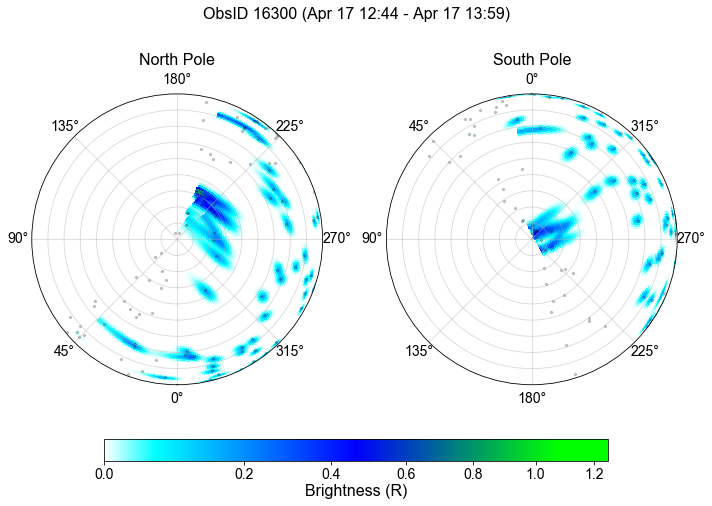

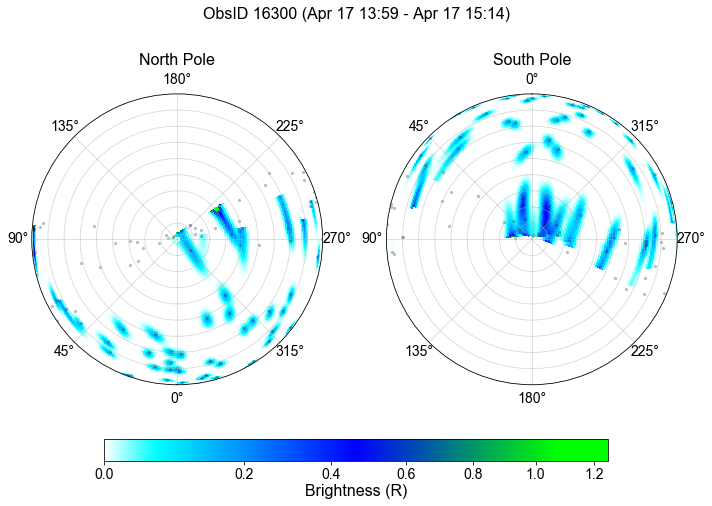

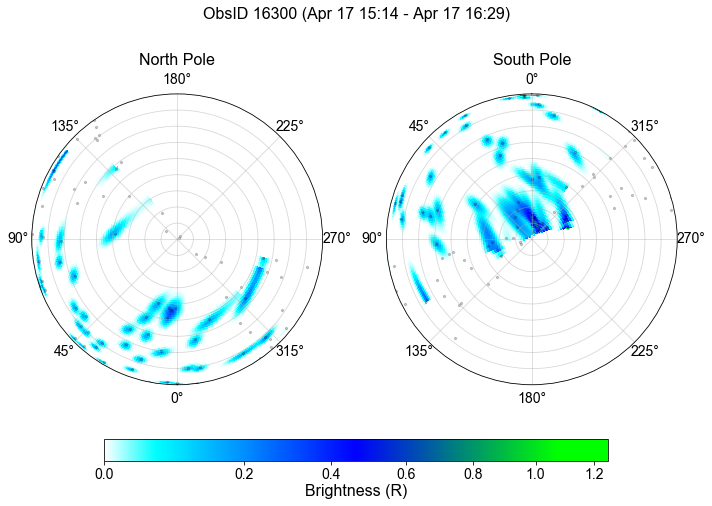

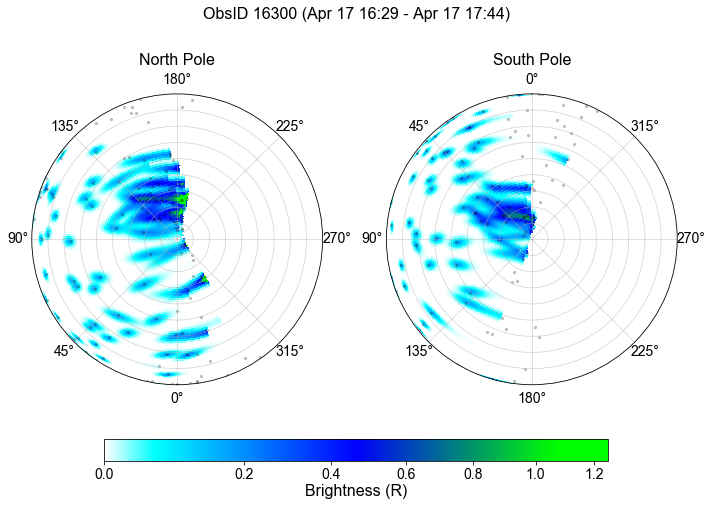

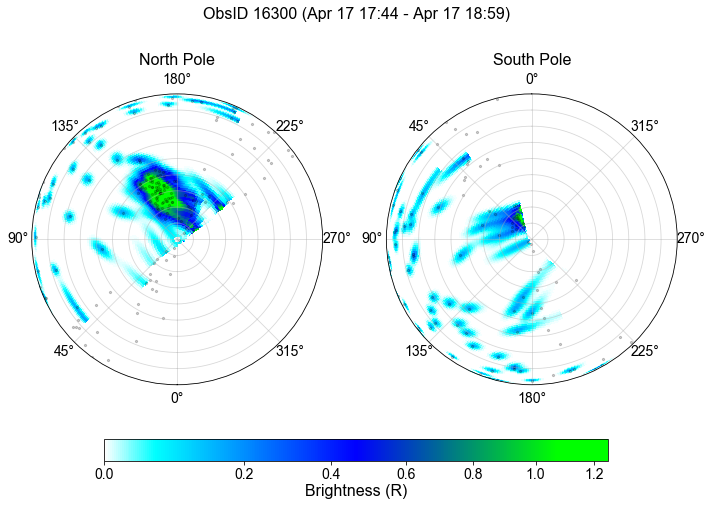

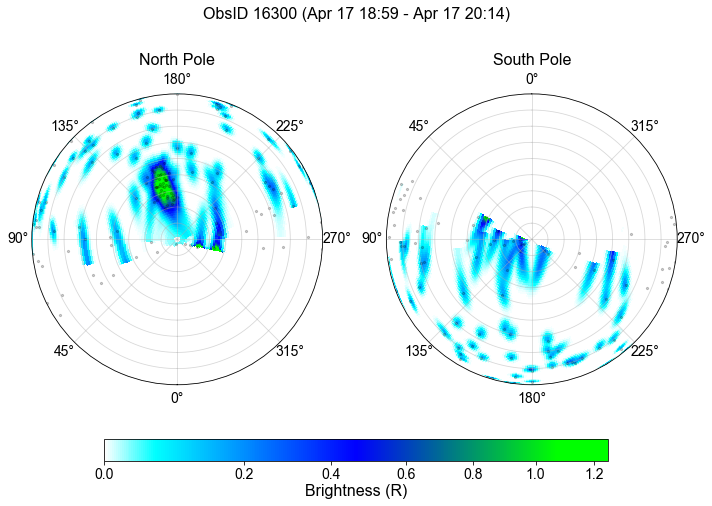

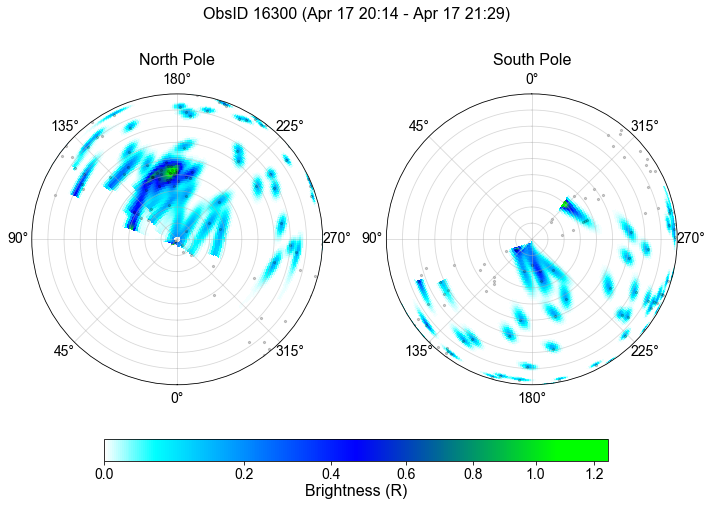

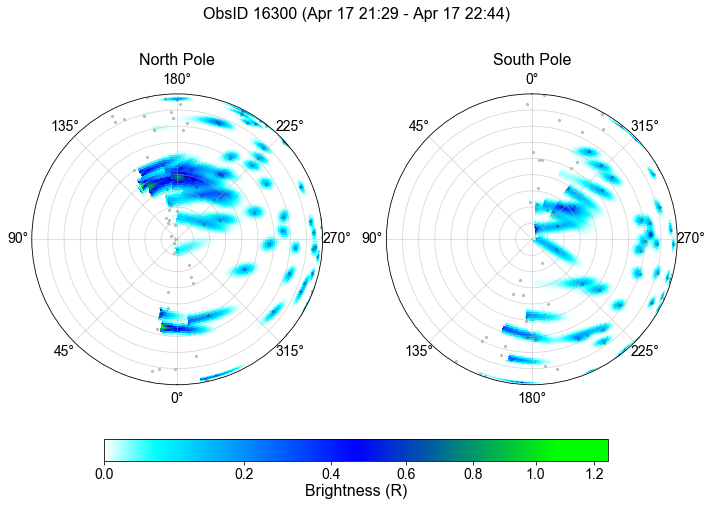

In [29]:
# Creating the custom color map for polar plots
c = colors.ColorConverter().to_rgb
custom_map = make_me_colors.make_cmap([c('white'), c('cyan'), 0.10, c('cyan'), c('blue'), 0.50, c('blue'),\
                                      c('lime'), 0.90, c('lime')])
# The color strings can be changed to what the user desires! Default: color map used in the Weigt et al. (in prep.)

# convert to X-ray brightness in Rayleighs - assuimg Aef = 40cm^2 (appropriate for 300eV X-rays)
conf = 4.0 * np.pi * 206264.806**2 / 1E6 / 1000 # equation explained in Weigt et al. (in prep.)

ratio = rad_pole_0/rad_eq_0 # ratio of polar radius to equatorial radius

# Defining azimuth angle and distance in polar plot
azimuth = np.deg2rad(np.arange(0,361)) # azimuth = S3 longitude in this system
# R deifned for both North and South poles using latitude. North: (0,90), South: (0, -90) 
R_np = 90.0*np.sqrt(1/(1/(ratio*np.tan(((np.deg2rad(90 - np.arange(0,91))))))**2 + 1))
R_sp = 90.0*np.sqrt(1/(1/(ratio*np.tan(((np.deg2rad(90 -np.arange(-91,0))))))**2 + 1))

np_polar_props_list = []
sp_polar_props_list = []
north_ph_sc_list = []
south_ph_sc_list = []
grid_R_np = []
grid_R_sp = []

# user prompted to set the max limit of brightness for polar plots (in Rayleighs (R))
max_brightness = eval(input("Enter the max limit for the brightness of polar plots (in Rayleighs): "))
    

# if a time interval has been used
if time_int_decision == 'y':
    # applying the conversion from a flux -> Rayleighs for the 2D PSFs
    for i in range(0, len(sup_props_list)):
        plot_time = Time.to_datetime(time_int_plot)

        for j in range(0, 92):
            np_polar_props = sup_props_list[i].T[j:, :]
            sp_polar_props = sup_props_list[i].T[:j, :]
            np_time_props = sup_time_props_list[i].T[j:,:]
            sp_time_props = sup_time_props_list[i].T[:j,:]
            np_bright_props = (np_polar_props/(np_time_props+0.001) * conf)
            sp_bright_props = (sp_polar_props/(sp_time_props+0.001) * conf)
        # adds the conversions to a new list
        np_polar_props_list.append(np_bright_props)
        sp_polar_props_list.append(sp_bright_props)
        # split into brightnesses for North and South pole and create a new list
        north_photons_pos = np.where((sup_lat_list[i]) >= 90)[0]
        south_photons_pos = np.where((sup_lat_list[i]) <= 90)[0] 
        north_ph_sc_list.append(north_photons_pos)
        south_ph_sc_list.append(south_photons_pos)
        # perfoming coordinate transformation on the photon position to be plotted on polar plot 
        az_scat = np.deg2rad(sup_lon_list[i])
        R_scat_np = 90.0*np.sqrt(1/(1/(ratio*np.tan(((np.deg2rad(sup_lat_list[i][north_photons_pos])-np.pi))))**2 + 1))
        R_scat_sp = 90.0*np.sqrt(1/(1/(ratio*np.tan(((np.deg2rad(sup_lat_list[i][south_photons_pos])-np.pi))))**2 + 1))
        grid_R_np.append(R_scat_np)
        grid_R_sp.append(R_scat_sp)
        
        # creating figure for North and South polar plots
        fig = plt.figure(figsize=(10,10))
        # left plot is North pole
        ax1 = plt.subplot(121, projection="polar")
        
        # creating the 2D polar plot with transformed values and custom color map...
        mesh_np = plt.pcolormesh(azimuth, R_np, np_bright_props, norm=colors.PowerNorm(gamma=0.7), vmin=0,\
                                 vmax = max_brightness,cmap=custom_map)
        #...with a scatter plot of the photon positions
        ax1.scatter(az_scat[north_photons_pos], R_scat_np, s=5, color='black', alpha=0.2)
        # editing polar plot to show 180 degrees at the top for North, setting the appropriate limits and other plotting functions
        ax1.set_theta_direction(-1)
        ax1.set_theta_offset(-np.pi/2)
        ax1.set_ylim(0,max(R_np))
        ax1.set_yticklabels([])
        ax1.set_title('North Pole', size = 16, y=1.08)
        plt.grid(alpha=0.5)

        # South pole is axis on the right
        ax2 = plt.subplot(122, projection="polar")
        
        # Exact same process for South...
        mesh_sp = plt.pcolormesh(azimuth, R_sp, sp_bright_props, norm=colors.PowerNorm(gamma=0.7), vmin=0, vmax = max_brightness ,cmap=custom_map)
        ax2.scatter(az_scat[south_photons_pos], R_scat_sp, s=5, color='black', alpha=0.2)
        #... except 0 degress is pointed at the top for South pole
        ax2.set_theta_offset(+np.pi/2)
        ax2.set_ylim(0,max(R_sp))
        ax2.set_yticklabels([])
        ax2.set_title('South Pole', size = 16, y=1.08)
        plt.grid(alpha=0.5)
        plt.tight_layout()
        
        # creating and formatting the color bar at the bottom of the plots
        cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.03])
        cbar = fig.colorbar(mesh_np, cax=cbar_ax, orientation="horizontal",fraction=0.2)
        cbar.set_label('Brightness (R)', labelpad = 2, size=16)
        # creating the title for the polar plots
        fig.subplots_adjust(top=1.3)
        fig.suptitle('ObsID %s (%s %02i %02i:%02i - %s %02i %02i:%02i)'\
                          %(obs_id,plot_time[i].strftime("%b"),plot_time[i].day,plot_time[i].hour, plot_time[i].minute,\
                            plot_time[i+1].strftime("%b"),plot_time[i+1].day,plot_time[i+1].hour, plot_time[i+1].minute),\
                                                                        size=16)
        # save polar plots to same folder as event file
        plt.savefig(str(folder_path) + '\%s_polar_plot_timeint%03i.png' % (obs_id,i+1), bbox_inches='tight')#, dpi=500)
       
else:
    # Lat and S3 longitude made into an array
    sup_lat_list, sup_lon_list = np.array(sup_lat_list), np.array(sup_lon_list)
    
     # applying the conversion from a flux -> Rayleighs for the 2D PSFs
    for j in range(0, 92):
        np_polar_props = sup_props_list.T[j:, :]
        sp_polar_props = sup_props_list.T[:j, :]
        np_time_props = sup_time_props_list.T[j:,:]
        sp_time_props = sup_time_props_list.T[:j,:]
        np_bright_props = (np_polar_props/(np_time_props+0.001) * conf)
        sp_bright_props = (sp_polar_props/(sp_time_props+0.001) * conf)
     # split into brightnesses for North and South pole 
    north_photons_pos = np.where(sup_lat_list >= 90)[0]
    south_photons_pos = np.where(sup_lat_list <= 90)[0] 
    # perfoming coordinate transformation on the photon position to be plotted on polar plot 
    az_scat = np.deg2rad(sup_lon_list)
    R_scat_np = 90.0*np.sqrt(1/(1/(ratio*np.tan(((np.deg2rad(sup_lat_list[north_photons_pos])-np.pi))))**2 + 1))
    R_scat_sp = 90.0*np.sqrt(1/(1/(ratio*np.tan(((np.deg2rad(sup_lat_list[south_photons_pos])-np.pi))))**2 + 1))
    
    # creating figure for North and South polar plots
    fig = plt.figure(figsize=(10,10))
    # left polar plot is North pole
    ax1 = plt.subplot(121, projection="polar")
    
    # creating the 2D polar plot with transformed values and custom color map...    
    mesh_np = plt.pcolormesh(azimuth, R_np, np_bright_props, cmap = custom_map,\
                            norm=colors.PowerNorm(gamma=0.7), vmin=0, vmax = max_brightness)
    #...with a scatter plot of the photon positions
    ax1.scatter(az_scat[north_photons_pos], R_scat_np, s=5, color='black', alpha = 0.2)
    # editing polar plot to show 180 degrees at the top for North, setting the appropriate limits and other plotting functions
    ax1.set_theta_direction(-1)
    ax1.set_theta_offset(-np.pi/2)
    ax1.set_ylim(0,90)
    ax1.set_yticks(np.arange(0, 91, 10))
    ax1.set_yticklabels(ax1.get_yticks()[::-1])
    ax1.set_yticklabels([])
    ax1.set_title('North Pole', size = 16, y=1.08)
    plt.grid(alpha=0.7)

    # South pole is axis on the right
    ax2 = plt.subplot(122, projection="polar")
    mesh = plt.pcolormesh(azimuth, R_sp, sp_bright_props,\
                         cmap=custom_map,norm=colors.PowerNorm(gamma=0.7), vmin=0, vmax = max_brightness)
    ax2.scatter(az_scat[south_photons_pos], R_scat_sp, s=5, color='black', alpha=0.2)
    #... except 0 degress is pointed at the top for South pole
    ax2.set_theta_offset(+np.pi/2)
    ax2.set_ylim(0,90)
    ax2.set_yticks(np.arange(0, 91, 10))
    ax2.set_yticklabels(ax2.get_yticks()[::-1])    
    ax2.set_yticklabels([])
    ax2.set_title('South Pole', size = 16, y=1.08)
    plt.grid(alpha=0.7)
    plt.tight_layout()
    # creating and formatting the color bar at the bottom of the plot    
    fig.subplots_adjust()
    cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.03])
    cbar = fig.colorbar(mesh, cax=cbar_ax, orientation="horizontal",fraction=0.2)
    cbar.set_label('Brightness (R)', labelpad=2, size=16)
    
    # creating the title for the polar plots
    fig.subplots_adjust(top=1.3)
    fig.suptitle('Chandra X-ray Jupiter Polar Maps - ObsID %s (%s %02i %02i:%02i - %s %02i %02i:%02i)' %(obs_id, plot_time[0].strftime("%b"),\
                                                                        plot_time[0].day,plot_time[0].hour, plot_time[0].minute,\
                                                                        plot_time[-1].strftime("%b"), plot_time[-1].day,plot_time[-1].hour,\
                                                                        plot_time[-1].minute), size=16)
    # save polar plots to same folder as event file             
    plt.savefig( str(folder_path) + '\%s_polar_plot_full_obs.png' % (obs_id), bbox_inches='tight',dpi=500)



The next few blocks of code is for when a time interval has been selected. The plots for both North and South are split into time intervals to observe the traversal of the hot spot throughout the observation. The format is similar to the previous polar plots.

C:\Users\dmw1n18\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[['a' 'b' 'c' 'd']
 ['e' 'f' 'g' 'h']]
Polar plot for hot spot traversal in North complete


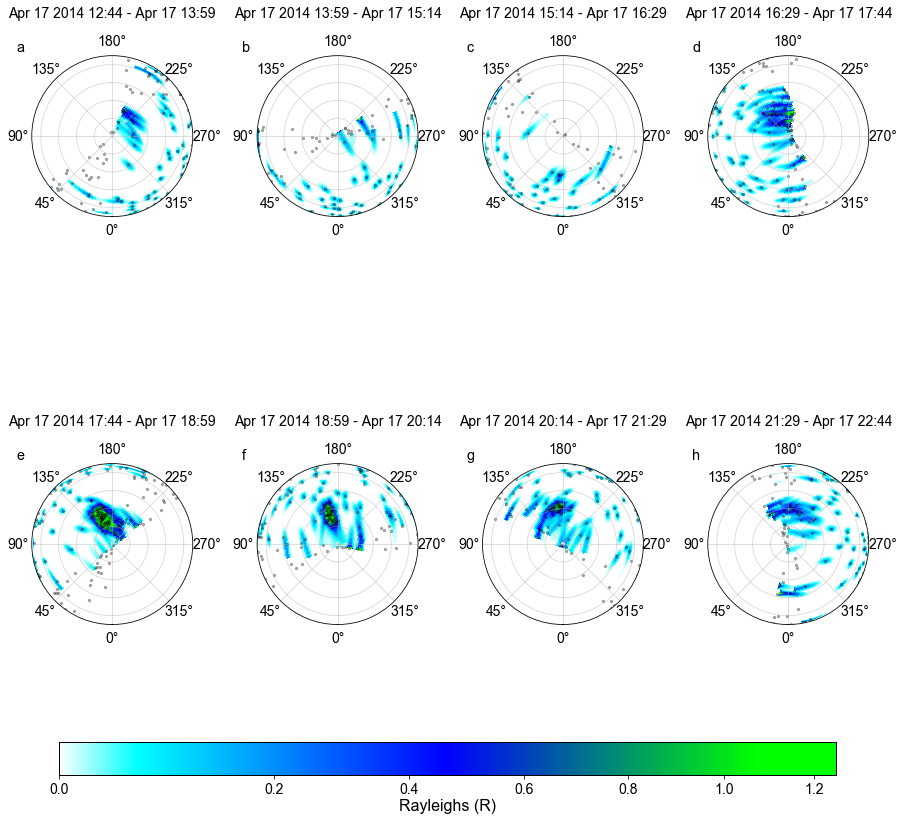

In [39]:
if time_int_decision == 'y':
    # defines a 2 X # of cols fird for the polar plots
    figsize=(15,15)
    cols = len(sup_props_list) // 2
    gs = gridspec.GridSpec(2, cols, wspace=0.4, hspace=0.001)
    ax =np.empty((2,cols), dtype=object)


    fig = plt.figure(num=4,figsize=figsize)
    # for each time interval...
    for k in range(len(sup_props_list)):

        plot_time = Time.to_datetime(time_int_plot) #... define the time used for plotting;...      
        row = (k // cols)
        col = k % cols #...define the placement of each plot by defining their placement within the axes and...
        #... perform the exact same polar plot routine as before but for the North only at each time interval.
        az_scat = np.deg2rad(sup_lon_list[k])

        ax[row,col] = fig.add_subplot(gs[row, col], projection = 'polar')
        ax[row,col].set_title('%s %02i %s %02i:%02i - %s %02i %02i:%02i'\
                              %(plot_time[k].strftime("%b"),plot_time[k].day,plot_time[k].year,plot_time[k].hour, plot_time[k].minute,\
                                plot_time[k+1].strftime("%b"),plot_time[k+1].day,plot_time[k+1].hour, plot_time[k+1].minute),\
                                                                            size=14, y=1.20)
        mesh_np = ax[row,col].pcolormesh(azimuth, R_np, np_polar_props_list[k], cmap=custom_map,norm=colors.PowerNorm(gamma=0.7),\
                                         vmin=0, vmax = max_brightness)

        ax[row,col].scatter(az_scat[north_ph_sc_list[k]], grid_R_np[k], s=5, color='black', alpha = 0.3)
        ax[row,col].set_theta_direction(-1)
        ax[row,col].set_theta_offset(-np.pi/2)
        ax[row,col].set_ylim(0,max(R_np))
        ax[row,col].set_yticklabels([])
        ax[row,col].grid(alpha=0.5)

        cbar_ax = fig.add_axes([0.15, 0.1, 0.72, 0.03])
        cbar = fig.colorbar(mesh_np, cax=cbar_ax, orientation="horizontal",fraction=0.1)
        cbar.set_label('Rayleighs (R)', labelpad = 2, size=16)
    # Using the label_maker.py script to plot the labels for each plot     
    make_me_labels.draw_labels(ax)
    #fig.savefig(str(folder_path) + '\%s_polar_plot_north_hs_traverse.png' % (obs_id), bbox_inches='tight',dpi=500)
    print('Polar plot for hot spot traversal in North complete')
    




C:\Users\dmw1n18\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[['a' 'b' 'c' 'd']
 ['e' 'f' 'g' 'h']]
Polar plot for hot spot traversal in South complete
Auroral morphology analysis complete!
Press [enter] to exit


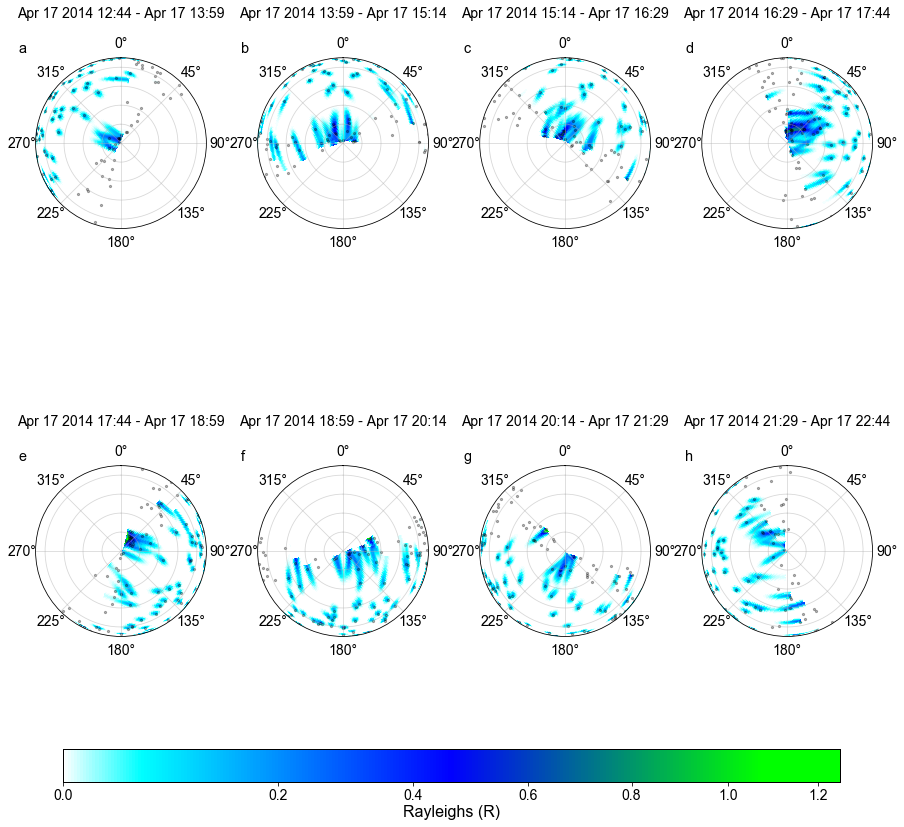

In [38]:
# Doing the exact same alogirthm for the South as defined for the North
if time_int_decision == 'y':

    figsize=(15,15)
    cols = len(sup_props_list) // 2
    gs = gridspec.GridSpec(2, cols, wspace=0.3, hspace=0.001)
    ax =np.empty((2,cols), dtype=object)


    fig = plt.figure(num=4,figsize=figsize)

    for k in range(len(sup_props_list)):

        plot_time = Time.to_datetime(time_int_plot)       
        row = (k // cols)
        col = k % cols
        #print(z)
        az_scat = np.deg2rad(sup_lon_list[k])

        ax[row,col] = fig.add_subplot(gs[row, col], projection = 'polar')
        ax[row,col].set_title('%s %02i %s %02i:%02i - %s %02i %02i:%02i'\
                              %(plot_time[k].strftime("%b"),plot_time[k].day,plot_time[k].year,plot_time[k].hour, plot_time[k].minute,\
                                plot_time[k+1].strftime("%b"),plot_time[k+1].day,plot_time[k+1].hour, plot_time[k+1].minute),\
                                                                            size=14, y=1.20)
        mesh_np = ax[row,col].pcolormesh(azimuth, R_sp, sp_polar_props_list[k], cmap=custom_map,norm=colors.PowerNorm(gamma=0.7),\
                                         vmin=0, vmax = max_brightness)

        ax[row,col].scatter(az_scat[south_ph_sc_list[k]], grid_R_sp[k], s=5, color='black', alpha = 0.3)
        ax[row,col].set_theta_direction(-1)
        ax[row,col].set_theta_offset(+np.pi/2)
        ax[row,col].set_ylim(0,max(R_np))
        ax[row,col].set_yticklabels([])
        ax[row,col].grid(alpha=0.5)
        cbar_ax = fig.add_axes([0.15, 0.1, 0.72, 0.03])
        cbar = fig.colorbar(mesh_np, cax=cbar_ax, orientation="horizontal",fraction=0.1)
        cbar.set_label('Rayleighs (R)', labelpad = 2, size=16)


    make_me_labels.draw_labels(ax)
    fig.savefig(str(folder_path) + '\%s_polar_plot_south_hs_traverse.png' % (obs_id), bbox_inches='tight',dpi=500)
    print('Polar plot for hot spot traversal in South complete')
    print('Auroral morphology analysis complete!')
    input('Press [enter] to exit')

else:
    # if 'n', then analysis is complete. Exit the program.
    print('Auroral morphology analysis complete!')
    input('Press [enter] to exit')


